# bias studies with full systematics

To assess the impact of various sources of systematic, we will rely on an Asimov dataset.

In [1]:
## imports and configuration
%cd '/home/naodell/work/wbr/analysis'
#%load_ext autoreload

from functools import partial
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from scipy.optimize import minimize, basinhopping
from scipy.stats import norm
from tqdm import tqdm_notebook

import scripts.plot_tools as pt
import scripts.fit_helpers as fh
from nllfit.nllfitter import ScanParameters

np.set_printoptions(precision=4)
rc_params = {
             'figure.figsize': (10, 10),
             'axes.labelsize': 20,
             'axes.facecolor': 'white',
             'axes.titlesize':'x-large',
             'legend.fontsize': 20,
             'xtick.labelsize':20,
             'ytick.labelsize':20,
             'font.size':18,
             'font.sans-serif':['Arial', 'sans-serif'],
             'mathtext.sf':'Arial',
             'lines.markersize':8.,
             'lines.linewidth':2.5,
            }
matplotlib.rcParams.update(rc_params)

%connect_info

/home/naodell/work/wbr/analysis
{
  "shell_port": 34115,
  "iopub_port": 51479,
  "stdin_port": 42359,
  "control_port": 36725,
  "hb_port": 57631,
  "ip": "127.0.0.1",
  "key": "bcae70a1-1a267fa64a4e9c3f901aa1c3",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": ""
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-b736e99f-e16d-4c40-adcc-3d796a87ce27.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.


In [2]:
# configure, get the input data, and do any additional processing that is needed
input_dir  = f'local_data/templates/updated_e_sf/'
processes = ['ttbar', 't', 'ww', 'wjets', 'zjets_alt', 'diboson', 'fakes'] 
selections = [
              'ee', 'mumu',  
              'emu', 
              'mutau', 'etau', 
              'mu4j', 'e4j'
             ]
plot_labels = fh.fancy_labels

# initialize fit data
fit_data = fh.FitData(input_dir, selections, processes, process_cut=0.01)
params = fit_data._parameters
params_pre = fit_data.get_params_init().values.copy()

In [3]:
# generate scan points
beta_scan_vals = ScanParameters(['beta_e', 'beta_mu', 'beta_tau'], 
                                [(0.104, 0.118), (0.104, 0.118), (0.104, 0.118)], 
                                [10, 10, 10]
                                )
scan_vals = np.array(beta_scan_vals.get_scan_vals()[0])
beta_h = np.transpose([1 - np.sum(scan_vals, axis=1)])
scan_vals = np.hstack((scan_vals, beta_h, np.outer(np.ones(scan_vals.shape[0]), params_pre[4:])))

In [ ]:
# carry out the scan #

# minimizer options
min_options = dict(
                   #eps=1e-10,
                   gtol=1e-2, 
                   disp=True
                  )

results = []
cost = []
sv_accept = []
pinit = params_pre[fit_data._pmask]
mask = fit_data._pmask.copy()
for sv in tqdm_notebook(scan_vals):
    
    # randomize n.p.
    mask[:4] = False
    np_random = params_pre[mask] + fit_data._perr_init[mask]*np.random.randn(mask.sum())
    fit_data._pval_init[mask] = np_random
    #sv[mask] = np_random
    mask[:4] = True
    
    # generate data from scan values w/ statistical variation
    sample = dict()
    for category in fit_data._categories:
        val, var = fit_data.mixture_model(sv, category)
        sample[category] = [np.random.poisson(val), val]

    # carry out minimization
    result = minimize(fit_data.objective, pinit,
                      method  = 'BFGS', 
                      options = min_options,
                      jac     = fit_data.objective_jacobian,
                      args    = (sample)
                     )
    print(' ', result.success, fit_data.objective(pinit), fit_data.objective(sv[mask]), result.fun)
    #print(' jacobian: ', result.jac)
    #print(' init vals: ', pinit)
    #print(' nps: ', np_random)
    print(' scan vals: ', sv[:4])
    print(' fit vals:', result.x[:4], end='\n\n')

    results.append(result.x)
    cost.append(result.fun)
    sv_accept.append(sv[mask])
    

         Current function value: 109.429759
         Iterations: 78
         Function evaluations: 121
         Gradient evaluations: 111
  False 1197.2493426768242 1555.9325287585864 109.42975940015677
 scan vals:  [0.104 0.104 0.104 0.688]
 fit vals: [0.1024 0.1031 0.1004 0.6941]

         Current function value: 118.559218
         Iterations: 83
         Function evaluations: 170
         Gradient evaluations: 158
  False 1217.4817574833933 1530.4952127151575 118.5592180652781
 scan vals:  [0.104  0.104  0.1056 0.6864]
 fit vals: [0.1058 0.1032 0.1062 0.6848]

         Current function value: 113.177804
         Iterations: 73
         Function evaluations: 194
         Gradient evaluations: 182
  False 1202.2264185611093 1474.974926737713 113.17780421759605
 scan vals:  [0.104  0.104  0.1071 0.6849]
 fit vals: [0.1041 0.105  0.1066 0.6843]

         Current function value: 143.494405
         Iterations: 77
         Function evaluations: 169
         Gradient evaluations: 158
  Fa

         Current function value: 123.253825
         Iterations: 56
         Function evaluations: 107
         Gradient evaluations: 96
  False 1205.9905706116392 1322.0159147770134 123.25382463611415
 scan vals:  [0.104  0.1071 0.1087 0.6802]
 fit vals: [0.103  0.1064 0.1091 0.6815]

         Current function value: 116.771563
         Iterations: 56
         Function evaluations: 163
         Gradient evaluations: 151
  False 1206.2207845207263 1308.05116800053 116.77156347851609
 scan vals:  [0.104  0.1071 0.1102 0.6787]
 fit vals: [0.104  0.1064 0.1096 0.68  ]

         Current function value: 125.123825
         Iterations: 68
         Function evaluations: 131
         Gradient evaluations: 120
  False 1205.330487313501 1298.231288732025 125.1238245633457
 scan vals:  [0.104  0.1071 0.1118 0.6771]
 fit vals: [0.1034 0.1065 0.1136 0.6765]

         Current function value: 121.144598
         Iterations: 64
         Function evaluations: 151
         Gradient evaluations: 140
  Fa

         Current function value: 102.532800
         Iterations: 47
         Function evaluations: 151
         Gradient evaluations: 139
  False 1214.958350706262 1928.9609051102568 102.53280018243075
 scan vals:  [0.104  0.1102 0.1133 0.6724]
 fit vals: [0.1037 0.1107 0.1123 0.6733]

         Current function value: 113.849678
         Iterations: 56
         Function evaluations: 115
         Gradient evaluations: 103
  False 1213.4830771529296 1943.1594211901743 113.84967756531981
 scan vals:  [0.104  0.1102 0.1149 0.6709]
 fit vals: [0.1047 0.111  0.1196 0.6646]

         Current function value: 111.803254
         Iterations: 52
         Function evaluations: 105
         Gradient evaluations: 95
  False 1200.0660246730354 1950.5768707245936 111.8032539171287
 scan vals:  [0.104  0.1102 0.1164 0.6693]
 fit vals: [0.1029 0.1098 0.1147 0.6727]

         Current function value: 119.643643
         Iterations: 40
         Function evaluations: 137
         Gradient evaluations: 126
 

         Current function value: 118.897786
         Iterations: 60
         Function evaluations: 132
         Gradient evaluations: 120
  False 1214.7322125101496 3325.9878032338256 118.89778618943163
 scan vals:  [0.104  0.1133 0.118  0.6647]
 fit vals: [0.1035 0.1131 0.1166 0.6668]

         Current function value: 124.687012
         Iterations: 71
         Function evaluations: 152
         Gradient evaluations: 141
  False 1211.8948753420273 4012.9766484701013 124.687011656283
 scan vals:  [0.104  0.1149 0.104  0.6771]
 fit vals: [0.1047 0.1145 0.1004 0.6804]

         Current function value: 123.678271
         Iterations: 61
         Function evaluations: 127
         Gradient evaluations: 116
  False 1213.8412699841501 4018.0464839417455 123.6782709254026
 scan vals:  [0.104  0.1149 0.1056 0.6756]
 fit vals: [0.1049 0.1154 0.1068 0.6729]

         Current function value: 109.504558
         Iterations: 62
         Function evaluations: 159
         Gradient evaluations: 147
 

         Current function value: 122.414703
         Iterations: 67
         Function evaluations: 125
         Gradient evaluations: 115
  False 1213.4414488246607 6231.524362258838 122.41470339208256
 scan vals:  [0.104  0.118  0.1071 0.6709]
 fit vals: [0.1036 0.1175 0.1059 0.6731]

         Current function value: 120.937927
         Iterations: 68
         Function evaluations: 167
         Gradient evaluations: 156
  False 1208.7416657185324 6252.316839580315 120.93792651705643
 scan vals:  [0.104  0.118  0.1087 0.6693]
 fit vals: [0.1051 0.1187 0.1091 0.6671]

         Current function value: 129.888490
         Iterations: 64
         Function evaluations: 133
         Gradient evaluations: 122
  False 1198.9872579909343 6273.400029844634 129.88848989453146
 scan vals:  [0.104  0.118  0.1102 0.6678]
 fit vals: [0.1034 0.1178 0.113  0.6658]

         Current function value: 117.757444
         Iterations: 66
         Function evaluations: 114
         Gradient evaluations: 103
 

         Current function value: 101.199053
         Iterations: 65
         Function evaluations: 124
         Gradient evaluations: 114
  False 1196.1384116659333 1048.893668583884 101.19905334862862
 scan vals:  [0.1056 0.1056 0.1118 0.6771]
 fit vals: [0.1049 0.1049 0.111  0.6792]

         Current function value: 123.687960
         Iterations: 69
         Function evaluations: 156
         Gradient evaluations: 144
  False 1211.0086038992624 1058.652169643377 123.6879602198986
 scan vals:  [0.1056 0.1056 0.1133 0.6756]
 fit vals: [0.1049 0.1053 0.1117 0.6781]

         Current function value: 119.807094
         Iterations: 62
         Function evaluations: 104
         Gradient evaluations: 93
  False 1220.8384779873113 1068.5693496449128 119.80709387169134
 scan vals:  [0.1056 0.1056 0.1149 0.674 ]
 fit vals: [0.1052 0.1052 0.1154 0.6742]

         Current function value: 130.601745
         Iterations: 63
         Function evaluations: 174
         Gradient evaluations: 163
  

         Current function value: 109.746252
         Iterations: 41
         Function evaluations: 89
         Gradient evaluations: 78
  False 1211.1962262299046 1400.9598124987906 109.74625174530514
 scan vals:  [0.1056 0.1087 0.1164 0.6693]
 fit vals: [0.1065 0.1087 0.1143 0.6705]

         Current function value: 114.962968
         Iterations: 47
         Function evaluations: 137
         Gradient evaluations: 125
  False 1203.4512391965527 1418.4547544243849 114.96296759903355
 scan vals:  [0.1056 0.1087 0.118  0.6678]
 fit vals: [0.1067 0.1094 0.1174 0.6665]

         Current function value: 120.448515
         Iterations: 42
         Function evaluations: 93
         Gradient evaluations: 84
  False 1204.8166651153751 1750.9467866122793 120.44851531679323
 scan vals:  [0.1056 0.1102 0.104  0.6802]
 fit vals: [0.1064 0.1117 0.1049 0.677 ]

         Current function value: 117.882910
         Iterations: 50
         Function evaluations: 103
         Gradient evaluations: 92
  F

         Current function value: 112.537011
         Iterations: 61
         Function evaluations: 126
         Gradient evaluations: 114
  False 1208.070219691981 3003.328381745941 112.53701061966855
 scan vals:  [0.1056 0.1133 0.1056 0.6756]
 fit vals: [0.1056 0.1134 0.1071 0.6739]

         Current function value: 111.001264
         Iterations: 58
         Function evaluations: 151
         Gradient evaluations: 139
  False 1203.5986495590719 3007.562432881838 111.00126382793228
 scan vals:  [0.1056 0.1133 0.1071 0.674 ]
 fit vals: [0.1052 0.113  0.1064 0.6754]

         Current function value: 125.327512
         Iterations: 57
         Function evaluations: 160
         Gradient evaluations: 149
  False 1200.4285171849099 3018.461152156021 125.32751246476222
 scan vals:  [0.1056 0.1133 0.1087 0.6724]
 fit vals: [0.1058 0.1143 0.109  0.6708]

         Current function value: 126.573654
         Iterations: 61
         Function evaluations: 156
         Gradient evaluations: 144
  

         Current function value: 139.009550
         Iterations: 68
         Function evaluations: 127
         Gradient evaluations: 116
  False 1221.6248260113005 5003.81638715914 139.0095501093735
 scan vals:  [0.1056 0.1164 0.1102 0.6678]
 fit vals: [0.1065 0.1161 0.1109 0.6665]

         Current function value: 125.890030
         Iterations: 64
         Function evaluations: 159
         Gradient evaluations: 148
  False 1209.3277374256447 5028.390244060822 125.89002958455816
 scan vals:  [0.1056 0.1164 0.1118 0.6662]
 fit vals: [0.1047 0.1149 0.1137 0.6667]

         Current function value: 120.950387
         Iterations: 71
         Function evaluations: 190
         Gradient evaluations: 178
  False 1207.5642018544333 5068.766548103557 120.9503872391902
 scan vals:  [0.1056 0.1164 0.1133 0.6647]
 fit vals: [0.1059 0.1166 0.1147 0.6628]

         Current function value: 109.056553
         Iterations: 71
         Function evaluations: 149
         Gradient evaluations: 138
  Fa

In [10]:
#calculate biases
results = np.array(results)
sv_accept = np.array(sv_accept)
cost = np.array(cost)

diff = (results - sv_accept)
diff[:,:4] /= 0.01*pinit[:4]
#diff[:,:4] /= 0.01*sv_accept[:,:4]
diff[:,4:diff.shape[1]] /= params['err_init'][4:diff.shape[1]].values

#diff = np.array([d for d in diff if np.all((d > -10) & (d < 10))])

/home/naodell/opt/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


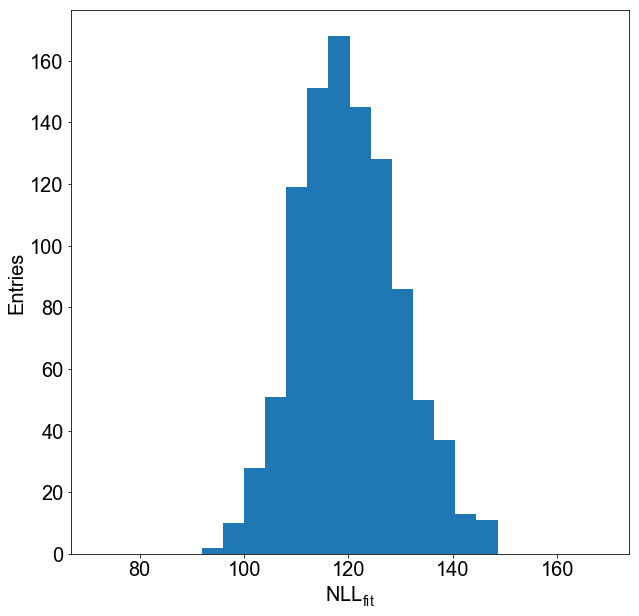

In [22]:
# plot the cost
fig, ax = plt.subplots(1, 1, figsize=(10, 10), facecolor='white')

cost = cost[cost<600]
cost_mean, cost_err = cost.mean(), cost.std()
ax.hist(cost, bins=np.linspace(np.max([0, cost_mean - 5*cost_err]), cost_mean + 5*cost_err, 25), histtype='stepfilled')
ax.set_xlabel(r'$NLL_{fit}$')
ax.set_ylabel('Entries')

plt.show()

/home/naodell/opt/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


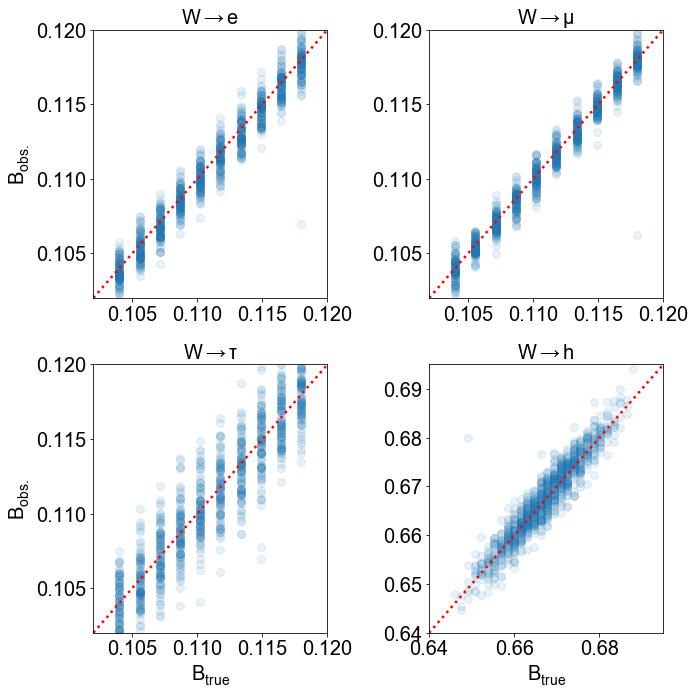

In [12]:
# branching fraction scans
fig, axes = plt.subplots(2, 2, figsize=(10, 10), facecolor='white', sharex=False, sharey=False)

beta_val = sv_accept[:,:4]
beta_obs = results[:,:4]

ax = axes[0][0]
ax.plot(beta_val[:,0], beta_obs[:,0], 'C0o', alpha=0.1)
ax.plot([0.1, 0.12], [0.1, 0.12], 'r:')
ax.set_xlim(0.102, 0.12)
ax.set_ylim(0.102, 0.12)
ax.set_ylabel(r'$B_{obs.}$')
ax.set_title(r'$W\rightarrow e$', size=20)

ax = axes[0][1]
ax.plot(beta_val[:,1], beta_obs[:,1], 'C0o', alpha=0.1)
ax.plot([0.1, 0.12], [0.1, 0.12], 'r:')
ax.set_xlim(0.102, 0.12)
ax.set_ylim(0.102, 0.12)
ax.set_title(r'$W\rightarrow\mu$', size=20)

ax = axes[1][0]
ax.plot(beta_val[:,2], beta_obs[:,2], 'C0o', alpha=0.1)
ax.plot([0.1, 0.12], [0.1, 0.12], 'r:')
ax.set_xlim(0.102, 0.12)
ax.set_ylim(0.102, 0.12)
ax.set_ylabel(r'$B_{obs.}$')
ax.set_xlabel(r'$B_{true}$')
ax.set_title(r'$W\rightarrow\tau$', size=20)

ax = axes[1][1]
ax.plot(beta_val[:,3], beta_obs[:,3], 'C0o', alpha=0.1)
ax.plot([0.64, 0.72], [0.64, 0.72], 'r:')
ax.set_xlim(0.64, 0.695)
ax.set_ylim(0.64, 0.695)
ax.set_xlabel(r'$B_{true}$')
ax.set_title(r'$W\rightarrow h$', size=20)

plt.tight_layout()
plt.savefig('plots/systematics/bias_tests/beta_scan.pdf')
plt.show()

/home/naodell/opt/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


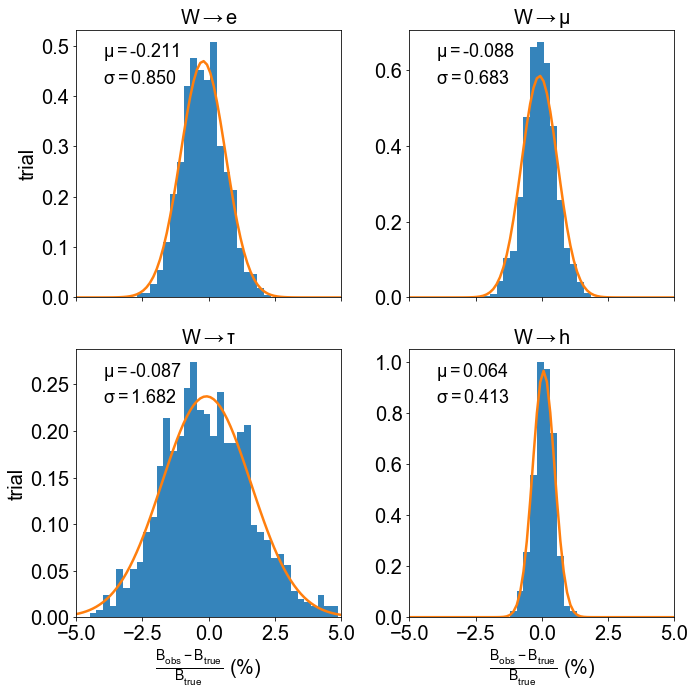

In [13]:
# branching fraction scans
fig, axes = plt.subplots(2, 2, figsize=(10, 10), facecolor='white', sharex=True, sharey=False)
bins = np.linspace(-5, 5, 80)

ax = axes[0][0]
dbeta = 100*(beta_obs[:,0] - beta_val[:,0])/beta_val[:,0]
ax.hist(dbeta, bins[::2], alpha=0.9, density=True)
ax.plot(bins, norm.pdf(bins, loc=dbeta.mean(), scale=dbeta.std()))
ax.text(0.1, 0.9, r'$\mu =$' + f'{dbeta.mean():.3f}', transform=ax.transAxes)
ax.text(0.1, 0.8, r'$\sigma =$' + f'{dbeta.std():.3f}', transform=ax.transAxes)
ax.set_xlim(-5., 5.)
ax.set_ylim(0., None)
ax.set_ylabel('trial')
ax.set_title(r'$W\rightarrow e$', size=20)

ax = axes[0][1]
dbeta = 100*(beta_obs[:,1] - beta_val[:,1])/beta_val[:,1]
ax.hist(dbeta, bins[::2], alpha=0.9, density=True)
ax.plot(bins, norm.pdf(bins, loc=dbeta.mean(), scale=dbeta.std()))
ax.text(0.1, 0.9, r'$\mu =$' + f'{dbeta.mean():.3f}', transform=ax.transAxes)
ax.text(0.1, 0.8, r'$\sigma =$' + f'{dbeta.std():.3f}', transform=ax.transAxes)
ax.set_title(r'$W\rightarrow\mu$', size=20)

ax = axes[1][0]
dbeta = 100*(beta_obs[:,2] - beta_val[:,2])/beta_val[:,2]
ax.hist(dbeta, bins[::2], alpha=0.9, density=True)
ax.plot(bins, norm.pdf(bins, loc=dbeta.mean(), scale=dbeta.std()))
ax.text(0.1, 0.9, r'$\mu =$' + f'{dbeta.mean():.3f}', transform=ax.transAxes)
ax.text(0.1, 0.8, r'$\sigma =$' + f'{dbeta.std():.3f}', transform=ax.transAxes)
ax.set_ylabel('trial')
ax.set_xlabel(r'$\frac{B_{obs} - B_{true}}{B_{true}}$ (%)')
ax.set_title(r'$W\rightarrow\tau$', size=20)

ax = axes[1][1]
dbeta = 100*(beta_obs[:,3] - beta_val[:,3])/beta_val[:,3]
ax.hist(dbeta, bins[::2], alpha=0.9, density=True)
ax.plot(bins, norm.pdf(bins, loc=dbeta.mean(), scale=dbeta.std()))
ax.text(0.1, 0.9, r'$\mu =$' + f'{dbeta.mean():.3f}', transform=ax.transAxes)
ax.text(0.1, 0.8, r'$\sigma =$' + f'{dbeta.std():.3f}', transform=ax.transAxes)
ax.set_xlabel(r'$\frac{B_{obs} - B_{true}}{B_{true}}$ (%)')
ax.set_title(r'$W\rightarrow h$', size=20)

plt.tight_layout()
plt.savefig('plots/systematics/bias_tests/beta_bias.pdf')
plt.show()

/home/naodell/opt/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/naodell/opt/anaconda3/lib/python3.7/site-packages/matplotlib/mathtext.py:834: MathTextWarning: Substituting with a symbol from Computer Modern.
  MathTextWarning)


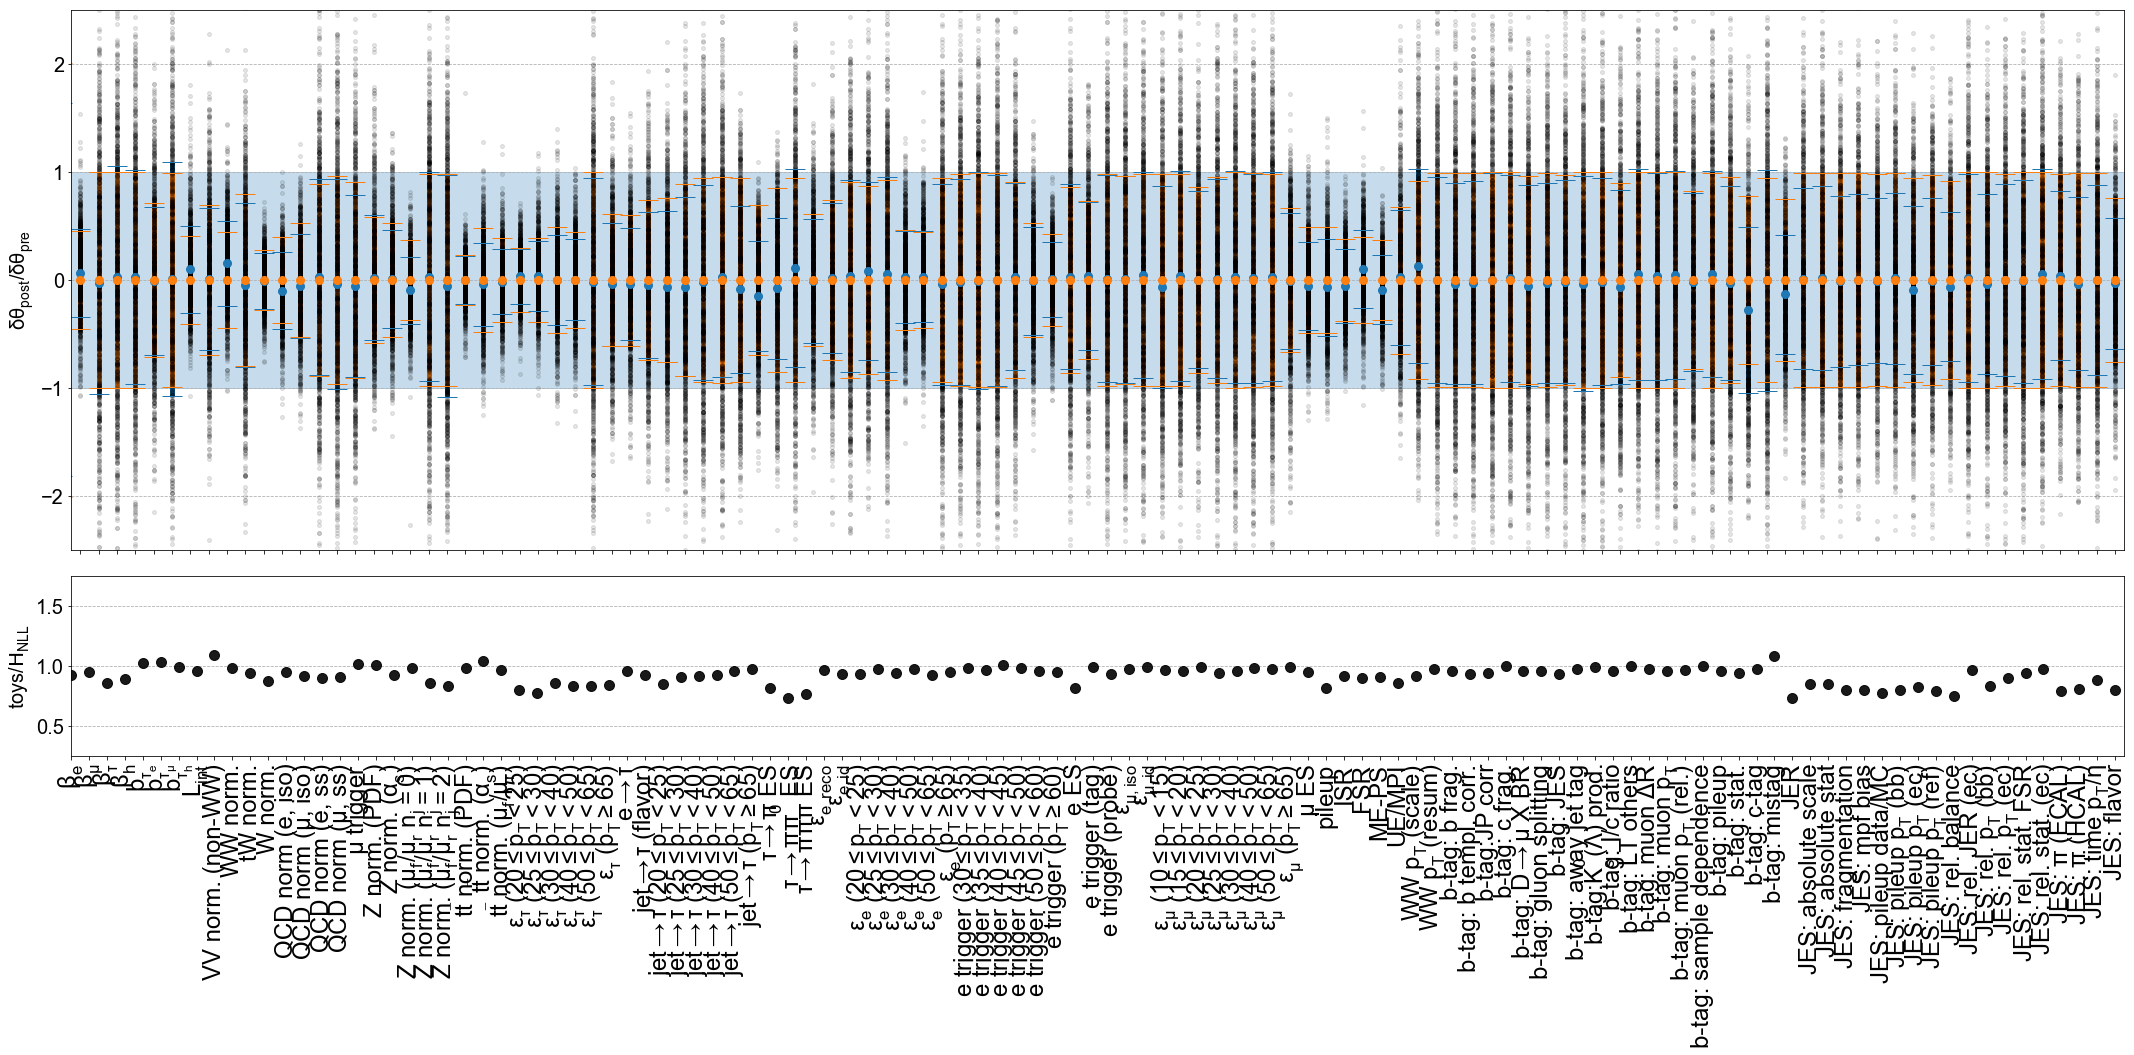

In [23]:
#plotting the results
fig, axes = plt.subplots(2, 1, figsize=(30, 15), facecolor='white', sharex=True, gridspec_kw={'height_ratios':[3,1]})

df_pulls = pd.read_csv('local_data/pulls.csv').query('active == True')
df_pulls.loc[:3, 'ratio'] *= 100
df_pulls = df_pulls.set_index('name')
#df_pulls = df_pulls.drop('top_pt')
pull_post = (df_pulls['val_fit'] - df_pulls['val_init'])/df_pulls['err_init']

nparams = params[mask].shape[0]
xticks = np.outer(np.arange(nparams), np.ones(diff.shape[0])).T
ax = axes[0]
ax.plot(xticks+1,  diff, 'ko', alpha=0.1, markersize=4, )
ax.errorbar(xticks[0]+1,  diff.mean(axis=0), diff.std(axis=0), fmt='C0o', capsize=10, elinewidth=5)
ax.errorbar(xticks[0]+1,  pull_post.values, df_pulls['ratio'], fmt='C1o', capsize=10, elinewidth=5)
ax.fill_between([-0.5, nparams+0.5], [-1, -1], [1, 1], color='C0', alpha=0.25)
#ax.boxplot(diff)

# extra dressing
ax.set_ylabel(r'$\delta\theta_{post}/\delta\theta_{pre}$')
ax.set_xlim(3.5, nparams+0.5)
ax.set_ylim(-2.5, 2.5)
ax.grid(linestyle='--', axis='y')

ax = axes[1]
err_ratio = diff.std(axis=0)/df_pulls['ratio'].values
ax.plot(xticks[0]+1,  err_ratio, 'ko', alpha=0.9, markersize=10)
#ax.errorbar(xticks[0]+1,  diff.mean(axis=0), , fmt='C0o', capsize=10, elinewidth=5)

ax.set_xticks(xticks[0]+1)
ax.set_xticklabels(params[mask].label, size=24)
plt.setp(ax.xaxis.get_majorticklabels(), rotation=90)

ax.set_ylabel(r'toys/$\mathcal{H}_{NLL}$')
ax.set_ylim(0.25, 1.75)
ax.grid(linestyle='--', axis='y')

plt.tight_layout()
plt.savefig('plots/new_pulls.pdf')
plt.show()

[0.8814 0.7095 1.7293 0.4064]


/home/naodell/opt/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


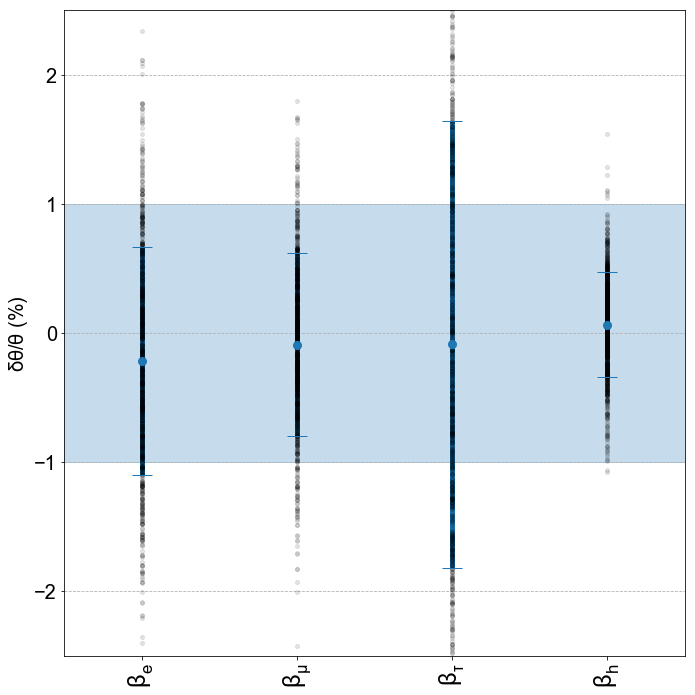

In [16]:
#plotting the results
fig, ax = plt.subplots(1, 1, figsize=(10, 10), facecolor='white')

xticks = np.outer(np.arange(4), np.ones(diff.shape[0])).T
ax.plot(xticks+1,  diff[:,:4], 'ko', alpha=0.1, markersize=4)
#ax.boxplot(diff)
ax.errorbar(xticks[0,:4]+1,  diff[:,:4].mean(axis=0), diff[:,:4].std(axis=0), fmt='C0o', capsize=10, elinewidth=5)
ax.fill_between([-0.5, nparams+0.5], [-1, -1], [1, 1], color='C0', alpha=0.25)

print(diff[:,:4].std(axis=0))

# extra dressing
ax.set_xticks(xticks[0,:4]+1)
ax.set_xticklabels(params.label[:4], size=24)
plt.setp(ax.xaxis.get_majorticklabels(), rotation=90)

ax.set_ylabel(r'$\delta\theta/\theta$ (%)')
ax.set_xlim(0.5, nparams+0.5)
ax.set_xlim(0.5, 4.5)
ax.set_ylim(-2.5, 2.5)
ax.grid(linestyle='--', axis='y')

plt.tight_layout()
plt.savefig('plots/systematics/bias_tests/beta.pdf')
plt.show()

/home/naodell/opt/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


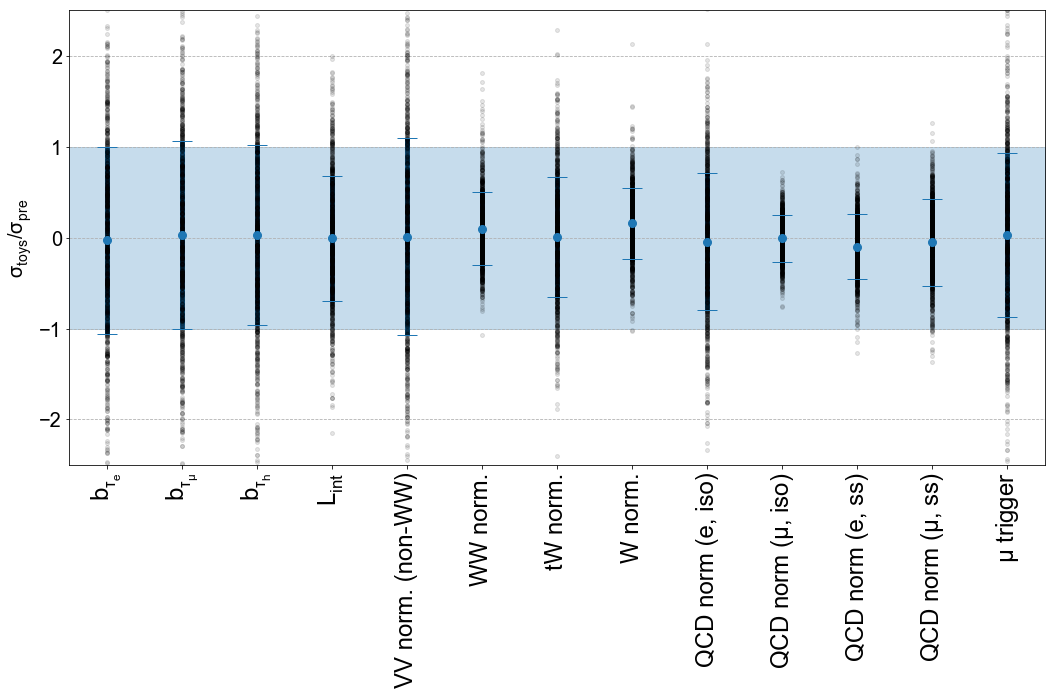

In [17]:
#plotting the results
fig, ax = plt.subplots(1, 1, figsize=(15, 10), facecolor='white')

ip_low, ip_high = 4, 7 + fit_data._nnorm
xticks = np.outer(np.arange(ip_high-ip_low), np.ones(diff.shape[0])).T
diff_trim = diff[:, ip_low:ip_high]
ax.plot(xticks+1,  diff_trim, 'ko', alpha=0.1, markersize=4, )
ax.errorbar(xticks[0]+1,  diff_trim.mean(axis=0), diff_trim.std(axis=0), fmt='C0o', capsize=10, elinewidth=5)

# extra dressing
ax.fill_between([0.5, ip_high - ip_low + 0.5], [-1, -1], [1, 1], color='C0', alpha=0.25)

ax.set_xticks(xticks[0]+1)
ax.set_xticklabels(params.label[ip_low:ip_high], size=24)
plt.setp(ax.xaxis.get_majorticklabels(), rotation=90)

ax.set_ylabel(r'$\sigma_{toys}/\sigma_{pre}$')
ax.set_xlim(0.5, ip_high - ip_low + 0.5)
ax.set_ylim(-2.5, 2.5)
ax.grid(linestyle='--', axis='y')

plt.tight_layout()
plt.savefig('plots/systematics/bias_tests/norm_params.pdf')
plt.show()

/home/naodell/opt/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/naodell/opt/anaconda3/lib/python3.7/site-packages/matplotlib/mathtext.py:834: MathTextWarning: Substituting with a symbol from Computer Modern.
  MathTextWarning)


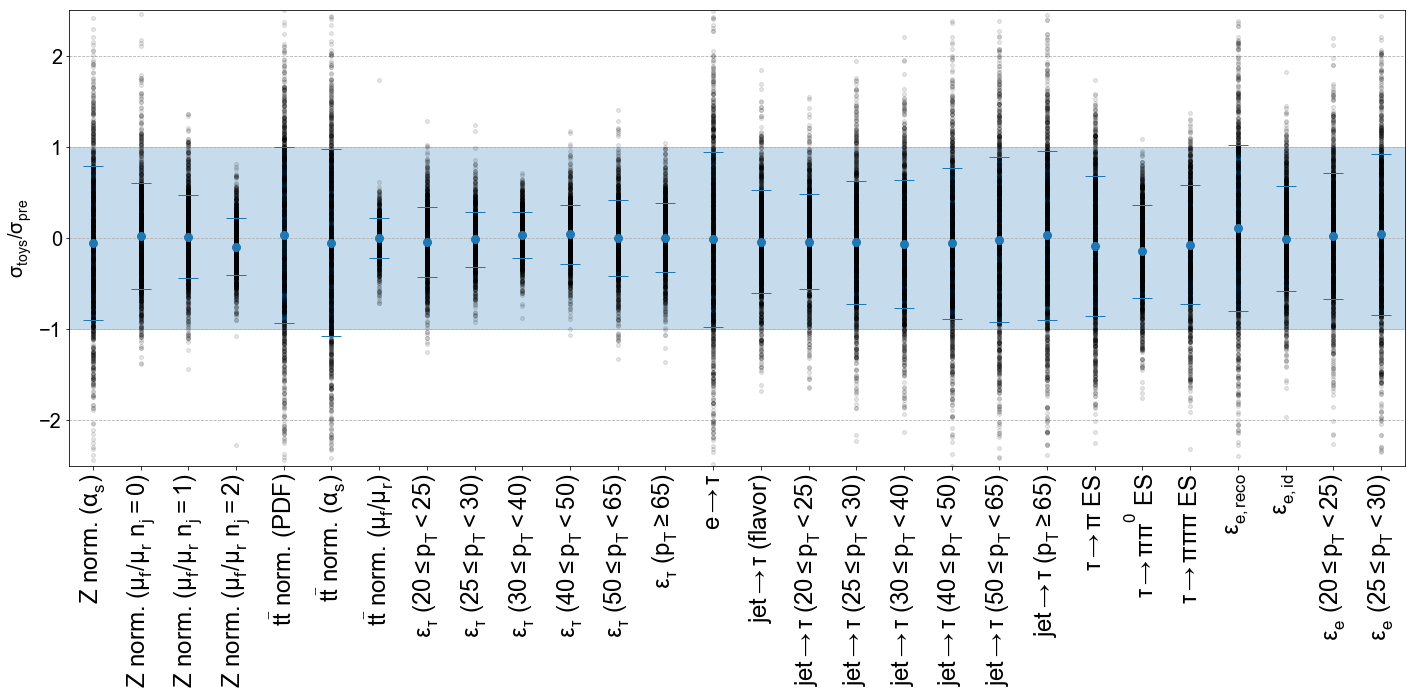

In [18]:
#plotting the results
fig, ax = plt.subplots(1, 1, figsize=(20, 10), facecolor='white')

ip_low, ip_high = 18, 46
xticks = np.outer(np.arange(ip_high-ip_low), np.ones(diff.shape[0])).T
diff_trim = diff[:, ip_low:ip_high]
ax.plot(xticks+1,  diff_trim, 'ko', alpha=0.1, markersize=4, )
ax.errorbar(xticks[0]+1,  diff_trim.mean(axis=0), diff_trim.std(axis=0), fmt='C0o', capsize=10, elinewidth=5)

# extra dressing
ax.fill_between([0.5, ip_high - ip_low + 0.5], [-1, -1], [1, 1], color='C0', alpha=0.25)

ax.set_xticks(xticks[0]+1)
ax.set_xticklabels(params.label[ip_low:ip_high], size=24)
plt.setp(ax.xaxis.get_majorticklabels(), rotation=90)

ax.set_ylabel(r'$\sigma_{toys}/\sigma_{pre}$')
ax.set_xlim(0.5, ip_high - ip_low + 0.5)
ax.set_ylim(-2.5, 2.5)
ax.grid(linestyle='--', axis='y')

plt.tight_layout()
plt.savefig('plots/systematics/bias_tests/shape_reco_params.pdf')
plt.show()

/home/naodell/opt/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


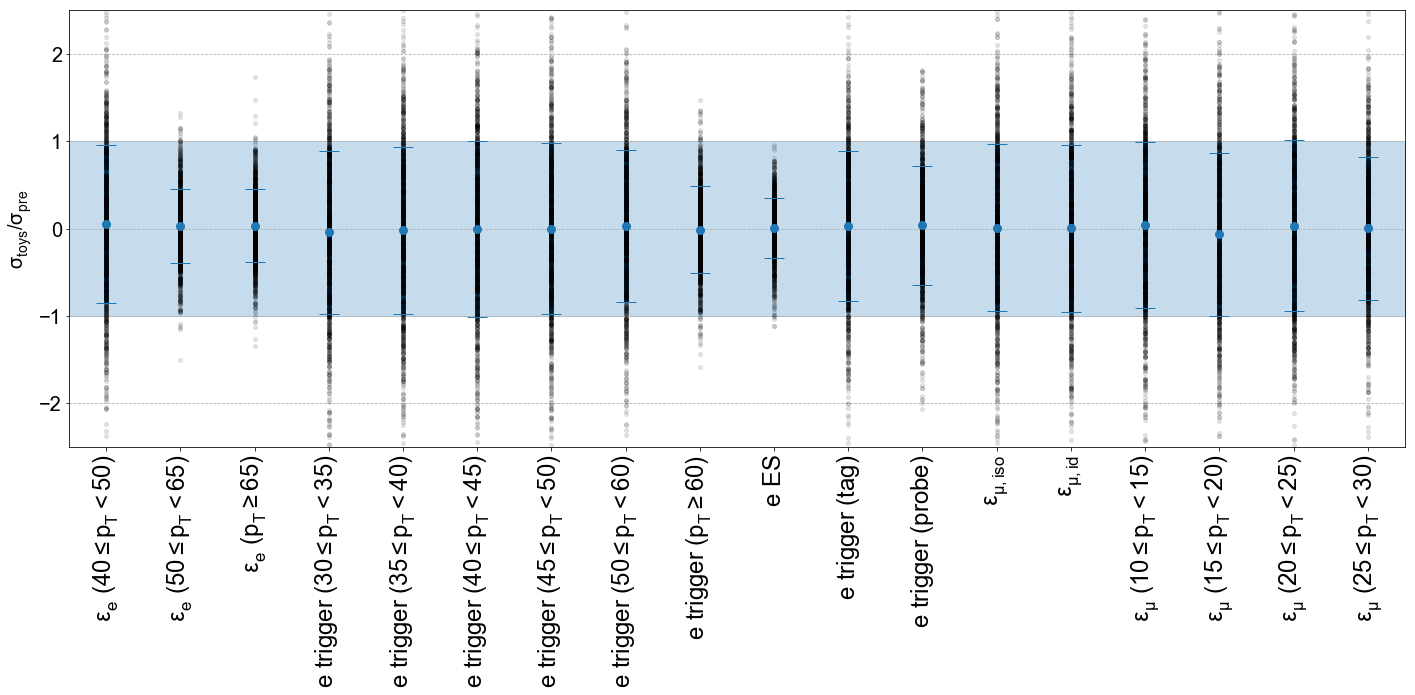

In [19]:
#plotting the results
fig, ax = plt.subplots(1, 1, figsize=(20, 10), facecolor='white')

ip_low, ip_high = 47, 65
xticks = np.outer(np.arange(ip_high-ip_low), np.ones(diff.shape[0])).T
diff_trim = diff[:, ip_low:ip_high]
ax.plot(xticks+1,  diff_trim, 'ko', alpha=0.1, markersize=4, )
ax.errorbar(xticks[0]+1,  diff_trim.mean(axis=0), diff_trim.std(axis=0), fmt='C0o', capsize=10, elinewidth=5)

# extra dressing
ax.fill_between([0.5, ip_high - ip_low + 0.5], [-1, -1], [1, 1], color='C0', alpha=0.25)

ax.set_xticks(xticks[0]+1)
ax.set_xticklabels(params.label[ip_low:ip_high], size=24)
plt.setp(ax.xaxis.get_majorticklabels(), rotation=90)

ax.set_ylabel(r'$\sigma_{toys}/\sigma_{pre}$')
ax.set_xlim(0.5, ip_high - ip_low + 0.5)
ax.set_ylim(-2.5, 2.5)
ax.grid(linestyle='--', axis='y')

plt.tight_layout()
plt.savefig('plots/systematics/bias_tests/shape_btag_params.pdf')
plt.show()

/home/naodell/opt/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


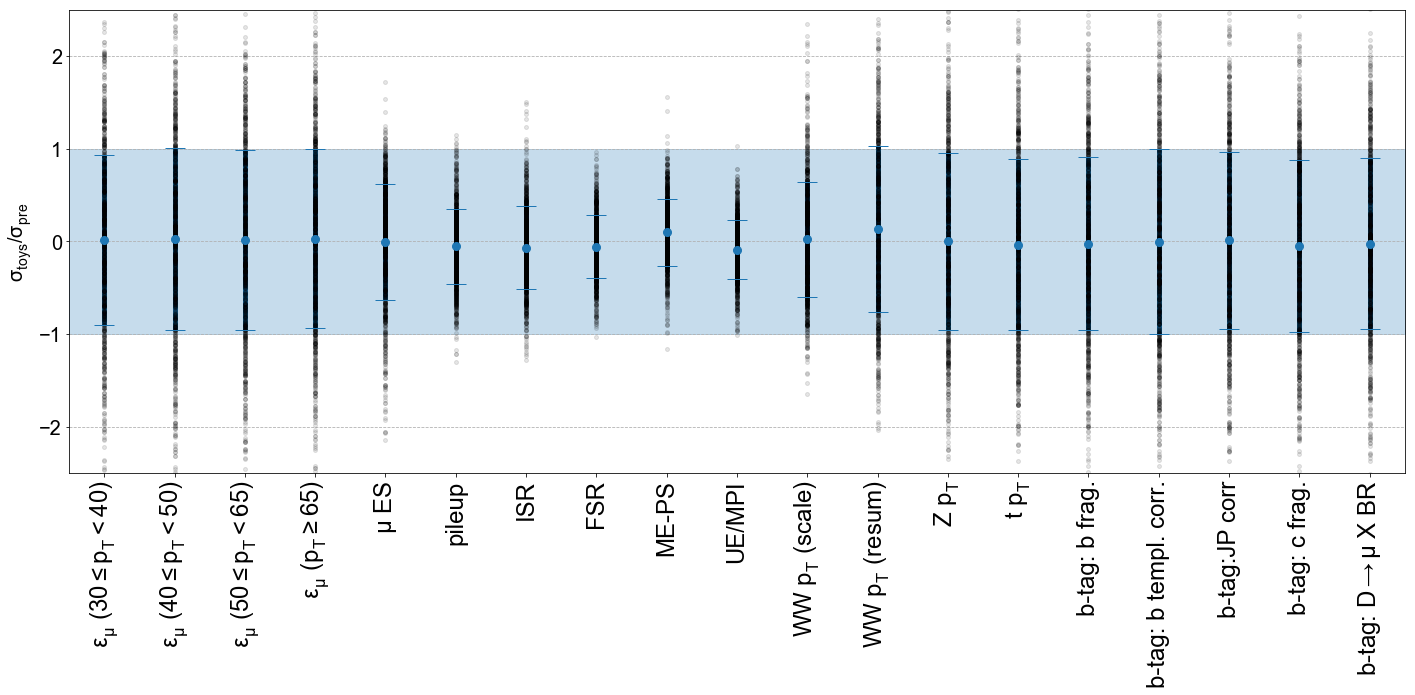

In [20]:
#plotting the results
fig, ax = plt.subplots(1, 1, figsize=(20, 10), facecolor='white')

ip_low, ip_high = 65, 84
xticks = np.outer(np.arange(ip_high-ip_low), np.ones(diff.shape[0])).T
diff_trim = diff[:, ip_low:ip_high]
ax.plot(xticks+1,  diff_trim, 'ko', alpha=0.1, markersize=4, )
ax.errorbar(xticks[0]+1,  diff_trim.mean(axis=0), diff_trim.std(axis=0), fmt='C0o', capsize=10, elinewidth=5)

# extra dressing
ax.fill_between([0.5, ip_high - ip_low + 0.5], [-1, -1], [1, 1], color='C0', alpha=0.25)

ax.set_xticks(xticks[0]+1)
ax.set_xticklabels(params.label[ip_low:ip_high], size=24)
plt.setp(ax.xaxis.get_majorticklabels(), rotation=90)

ax.set_ylabel(r'$\sigma_{toys}/\sigma_{pre}$')
ax.set_xlim(0.5, ip_high - ip_low + 0.5)
ax.set_ylim(-2.5, 2.5)
ax.grid(linestyle='--', axis='y')

plt.tight_layout()
plt.savefig('plots/systematics/bias_tests/shape_jes_params.pdf')
plt.show()